In [1]:
import zeus21
from matplotlib import pyplot as plt
import numpy as np
from zeus21 import LIM
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d

import scipy.fftpack as fft
from scipy import ndimage

from matplotlib.cm import get_cmap

#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
plt.rcParams['lines.linewidth'] = 2
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

In [2]:
# define all the input params
CosmoParams_input = zeus21.Cosmo_Parameters_Input(HMF_CHOICE='ST')
CosmoParams_use,ClassyCosmo_use, CorrFclass_21_use ,HMFintclass_use =  zeus21.cosmo_wrapper(CosmoParams_input)
AstroParams_use = zeus21.Astro_Parameters(CosmoParams_use,STOCHASTICITY = False,)

ZMIN = 10.0 #down to which z we compute the evolution
CoeffStructure_21_use = zeus21.get_T21_coefficients(CosmoParams_use, ClassyCosmo_use, AstroParams_use, HMFintclass_use, zmin=ZMIN)

RSDMODE = 0 #which RSD mode you want, 0 is no RSDs (real space), 1 is spherical (as simulations usually take), 2 is mu~1 (outside the wedge, most relevant for observations)
PS21_use = zeus21.Power_Spectra(CosmoParams_use, AstroParams_use, ClassyCosmo_use, CorrFclass_21_use, CoeffStructure_21_use, RSD_MODE = RSDMODE)

Lbox = 100
Nbox = 150 

In [3]:
LineParams_input_use = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 2,  
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_0 = 7.1-0.07*10,
                 CII_beta_SFR_z = 0.,
                 CII_sigma_LSFR = 0.)

LineParams_use = zeus21.Line_Parameters(LineParams_input_use) 

CoeffStructure_LIM_use = zeus21.get_LIM_coefficients(CosmoParams_use,  AstroParams_use, HMFintclass_use, LineParams_use, zmin=ZMIN)
CorrFClass_LIM_use = zeus21.Correlations_LIM(LineParams_use, CosmoParams_use, ClassyCosmo_use)
PSLIM_use = zeus21.Power_Spectra_LIM(CosmoParams_use, AstroParams_use, LineParams_use, CorrFClass_LIM_use, 'here we will put 21cm coeffs', CoeffStructure_LIM_use, RSD_MODE = RSDMODE)


In [4]:
def Interpolation_SFRD_delta(z0, R0, LineParams, AstroParams, HMFintclass, CosmoParams, use_interpolation, input_delta_array, input_sigmaR):

    if use_interpolation:
        sigmaR = HMFintclass.sigmaRintlog((np.log(R0), z0))

        Nsigmad = 2.0 #how many sigmas we explore
        Nds = 1001 #how many deltas

        # Create a log-spaced array for positive values
        pos = np.logspace(-10, np.log10(Nsigmad), int(Nds/2))  
        neg = -pos[::-1]  # Mirror for negative side
        # Combine negative and positive parts
        deltatab_norm = np.concatenate((neg, pos))

        deltaArray = deltatab_norm * sigmaR
    
    else:
        deltaArray = input_delta_array * input_sigmaR
        sigmaR = input_sigmaR
    
    mArray, deltaArray_Mh = np.meshgrid(HMFintclass.Mhtab, deltaArray, indexing = 'ij', sparse = True)

    sigmaM = HMFintclass.sigmaintlog((np.log(mArray),z0))

    modSigmaSq = sigmaM**2 - sigmaR**2
    indexTooBig = (modSigmaSq <= 0.0)
    modSigmaSq[indexTooBig] = np.inf #if sigmaR > sigmaM the halo does not fit in the radius R. Cut the sum
    modSigma = np.sqrt(modSigmaSq)

    nu0 = CosmoParams.delta_crit_ST / sigmaM
    nu0[indexTooBig] = 1.0
    modd = CosmoParams.delta_crit_ST - deltaArray_Mh
    nu = modd / modSigma

    EPS_HMF_corr = (nu/nu0) * (sigmaM/modSigma)**2.0 * np.exp(-CosmoParams.a_corr_EPS * (nu**2-nu0**2)/2.0 ) * (1.0 + deltaArray_Mh)

    HMF_curr = np.exp(HMFintclass.logHMFint((np.log(mArray),z0)))
    SFRtab_currII = zeus21.sfrd.SFR_II(AstroParams, CosmoParams, HMFintclass, mArray, z0, 0.)

    integrand = EPS_HMF_corr *  HMF_curr * SFRtab_currII * HMFintclass.Mhtab[:,np.newaxis]

    integrand_LIM = EPS_HMF_corr *  HMF_curr * LIM.LineLuminosity(SFRtab_currII, LineParams, AstroParams, CosmoParams, HMFintclass, mArray, z0)  * HMFintclass.Mhtab[:,np.newaxis]

    SFRDbox_flattend = np.trapezoid(integrand, HMFintclass.logtabMh, axis = 0) 

    Lbox_flattened = np.trapezoid(integrand_LIM,HMFintclass.logtabMh, axis = 0)

    if use_interpolation:

        interpolate_funct = interp1d(deltaArray, SFRDbox_flattend, kind='cubic',bounds_error=True)

        SFRDbox_flattend = interpolate_funct(input_delta_array * input_sigmaR)

        interpolate_LIM_funct = interp1d(deltaArray, Lbox_flattened, kind='linear',bounds_error=True)

        Lbox_flattened = interpolate_LIM_funct(input_delta_array * input_sigmaR)


    return SFRDbox_flattend, Lbox_flattened

In [5]:
def all_boxes(z0,Lbox,Nbox,PS,CoeffStructure21, LineParams, AstroParams, HMFintclass, CosmoParams, use_interpolation):
    
    Mapz12 = zeus21.CoevalMaps(CoeffStructure21, PS, z0, KIND=1,Lbox=Lbox,Nbox=Nbox) #can set Lbox, Nbox, and seed

    delta_box = Mapz12.deltamap
    variance = np.var(delta_box)
    sigmaR = np.sqrt(variance)

    R0 = Lbox / Nbox
    SFRDbox_flattend, Lbox_flattend = Interpolation_SFRD_delta(z0, R0, LineParams, AstroParams, HMFintclass, CosmoParams, use_interpolation, delta_box.flatten(), sigmaR)

    delta_box_sigmaR = delta_box * sigmaR
    SFRD_box = SFRDbox_flattend.reshape(Nbox,Nbox,Nbox)
    L_box = Lbox_flattend.reshape(Nbox,Nbox,Nbox)

    if LineParams.LINE == 'CO':
        nu_line_rest = -1
    elif LineParams.LINE == 'CII':
        nu_line_rest = LineParams.CII_nu_rest
    else:
        nu_line_rest = -1

    if LineParams.OBSERVABLE_LIM == 'Tnu':

        # c1 = uK / Lsun * Mpc^3
        coeff1_LIM = (((zeus21.constants.c_kms * LIM.au.km/LIM.au.s)**3 * (1+z0)**2 / (8*np.pi * (zeus21.cosmology.Hub(CosmoParams, z0) * LIM.au.km/LIM.au.s/LIM.au.Mpc) * (nu_line_rest * LIM.au.Hz)**3 * LIM.ac.k_B)).to(LIM.au.uK * LIM.au.Mpc**3 / LIM.au.Lsun )).value

        # c2 = Lbar = Lsun / Mpc^3 
        coeff2_LIM = 1.

        # --> c1*c2 = uK

    elif LineParams.OBSERVABLE_LIM == 'Inu':

        # nu_rest for CII is in Hz, speed of light in km / s , Hubble in km / s / Mpc --> c1 = cm / sr / Hz
        coeff1_LIM = ((zeus21.constants.c_kms * LIM.au.km/LIM.au.s) / (4*np.pi * (zeus21.cosmology.Hub(CosmoParams, z0) * LIM.au.km/LIM.au.s/LIM.au.Mpc) * nu_line_rest * LIM.au.Hz)) * zeus21.constants.Mpctocm

        # c2 = Lbar = Lsun / Mpc^3 
        coeff2_LIM = 1. / zeus21.constants.Mpctocm**3

    Inu_box = L_box * coeff1_LIM * coeff2_LIM 

    return delta_box_sigmaR, SFRD_box, L_box, Inu_box

In [6]:
zv = 10.

map_delta, map_SFRD, map_rhoLIM, map_InuLIM = all_boxes(zv,Lbox,Nbox,PS=PS21_use,CoeffStructure21=CoeffStructure_21_use,CosmoParams=CosmoParams_use,HMFintclass=HMFintclass_use,AstroParams=AstroParams_use,LineParams = LineParams_use, use_interpolation = False)

map_delta_interp, map_SFRD_interp, map_rhoLIM_interp, map_InuLIM_interp = all_boxes(zv,Lbox,Nbox,PS=PS21_use,CoeffStructure21=CoeffStructure_21_use,CosmoParams=CosmoParams_use,HMFintclass=HMFintclass_use,LineParams = LineParams_use, AstroParams=AstroParams_use,use_interpolation = True)


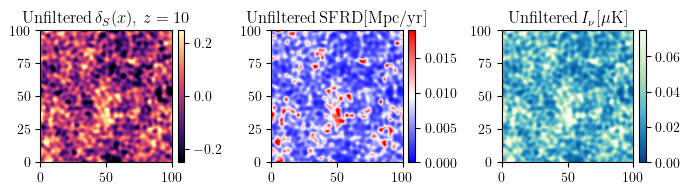

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(7,2))

_islice = 0

im = ax[0].imshow(map_delta[_islice],extent=(0,Lbox,0,Lbox),cmap='magma',vmax =0.25, vmin = -0.25) 
cbar1 = fig.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)
ax[0].set_title(r'${\rm Unfiltered}\,\delta_S(x),\,z=%g$'%zv)

# im = ax[0,1].imshow(map_delta_interp[_islice],extent=(0,Lbox,0,Lbox),cmap='magma',vmax =0.25, vmin = -0.25)
# cbar1 = fig.colorbar(im, ax=ax[0,1], fraction=0.046, pad=0.04)
# ax[0,1].set_title(r'${\rm Interpolated}\,\delta_S(x)$')

# im = ax[0,2].imshow(100.*(map_delta[_islice]-map_delta_interp[_islice])/map_delta[_islice],extent=(0,Lbox,0,Lbox),cmap='grey')
# cbar1 = fig.colorbar(im, ax=ax[0,2], fraction=0.046, pad=0.04)
# ax[0,2].set_title(r'$[\delta_S(x)-{\rm interp}]/\delta_S (\%)$')

im = ax[1].imshow((map_SFRD[_islice]),extent=(0,Lbox,0,Lbox),cmap='bwr',vmax=0.019,vmin=0.)
cbar1 = fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
ax[1].set_title(r'${\rm Unfiltered}\,{\rm SFRD} [{\rm Mpc/yr}]$')

# im = ax[1,1].imshow((map_SFRD_interp[_islice]),extent=(0,Lbox,0,Lbox),cmap='bwr',vmax=0.025,vmin=0.)
# cbar1 = fig.colorbar(im, ax=ax[1,1], fraction=0.046, pad=0.04)
# ax[1,1].set_title(r'${\rm Interpolated}\,{\rm SFRD} [{\rm Mpc/yr}]$')

# im = ax[1,2].imshow(100*(map_SFRD[_islice]-map_SFRD_interp[_islice])/map_SFRD[_islice],extent=(0,Lbox,0,Lbox),cmap='grey')
# cbar1 = fig.colorbar(im, ax=ax[1,2], fraction=0.046, pad=0.04)
# ax[1,2].set_title(r'$[{\rm SFRD\,-\,interp]/SFRD}(\%)$')

# im = ax[2,0].imshow((map_rhoLIM[_islice]),extent=(0,Lbox,0,Lbox),cmap=get_cmap('GnBu_r'))
# cbar1 = fig.colorbar(im, ax=ax[2,0], fraction=0.046, pad=0.04)
# ax[2,0].set_title(r'${\rm Unfiltered}\,{\rho_L}(z=%g$'%10.+r'$.{x})$')

# im = ax[2,1].imshow((map_rhoLIM_interp[_islice]),extent=(0,Lbox,0,Lbox),cmap=get_cmap('GnBu_r'))
# cbar1 = fig.colorbar(im, ax=ax[2,1], fraction=0.046, pad=0.04)
# ax[2,1].set_title(r'${\rm Interpolated}\,{\rho_L}(z=%g$'%10.+r'$.{x})$')

# im = ax[2,2].imshow(100*(map_rhoLIM[_islice]-map_rhoLIM_interp[_islice])/map_rhoLIM[_islice],extent=(0,Lbox,0,Lbox),cmap='grey')
# cbar1 = fig.colorbar(im, ax=ax[2,2], fraction=0.046, pad=0.04)
# ax[2,2].set_title(r'$[{\rho_L\,-\rm \,interp]/\rho_L}(\%)$')

im = ax[2].imshow((map_InuLIM[_islice]),extent=(0,Lbox,0,Lbox),cmap=get_cmap('GnBu_r'),vmax=0.075,vmin=0.)
cbar1 = fig.colorbar(im, ax=ax[2], fraction=0.046, pad=0.04)
ax[2].set_title(r'${\rm Unfiltered}\,{I_\nu} [\mu{\rm K}]$')

# im = ax[2,1].imshow((map_InuLIM_interp[_islice]),extent=(0,Lbox,0,Lbox),cmap=get_cmap('GnBu_r'),vmax=0.1,vmin=0.)
# cbar1 = fig.colorbar(im, ax=ax[2,1], fraction=0.046, pad=0.04)
# ax[2,1].set_title(r'${\rm Interpolated}\,{I_\nu} [\mu {\rm K}]$')

# im = ax[2,2].imshow(100*(map_InuLIM[_islice]-map_InuLIM_interp[_islice])/map_InuLIM[_islice],extent=(0,Lbox,0,Lbox),cmap='grey')
# cbar1 = fig.colorbar(im, ax=ax[2,2], fraction=0.046, pad=0.04)
# ax[2,2].set_title(r'$[{I_\nu\,-\rm \,interp]/I_\nu}(\%)$')

plt.tight_layout()
plt.savefig('./plots/all_boxes_' + str(zv) + '.png')
plt.show()


In [8]:
def top_hat_filter(k, R):
    """Top-hat filter in k-space, avoiding division by zero."""
    kR = k * R
    W = np.zeros_like(k)
    mask = kR > 0
    W[mask] = 3 * (np.sin(kR[mask]) - kR[mask] * np.cos(kR[mask])) / (kR[mask]**3)
    W[~mask] = 1.0  # Ensure W(0) = 1
    
    return W

In [9]:
def smoothed_boxes(z0,R0,Lbox,Nbox,PS,CoeffStructure, LineParams, AstroParams, HMFintclass, CosmoParams, use_interpolation, smooth_type):

    density_vals, SFRD_box_vals, rhoL_box_vals, Inu_box_vals = all_boxes(z0,Lbox,Nbox,PS,CoeffStructure, LineParams, AstroParams, HMFintclass, CosmoParams, use_interpolation)
    
    if 2*R0 < Lbox/Nbox:
        print('\n\nYou cannot smooth over R smaller than the cell size!!!\n\n')
        return density_vals,SFRD_box_vals,rhoL_box_vals, Inu_box_vals
    elif 2*R0 > Lbox:
        print('\n\nYou cannot smooth over R larger than the box size!!!\n\n')
        return density_vals,SFRD_box_vals,rhoL_box_vals, Inu_box_vals
 
    input_ = fft.fftn(density_vals)
    input_SFRD = fft.fftn(SFRD_box_vals)
    input_rhoL = fft.fftn(rhoL_box_vals)
    input_Inu = fft.fftn(Inu_box_vals)

    if smooth_type == 'gauss':

        result_fft = ndimage.fourier_gaussian(input_, sigma= R0 )
        density_smoothed_R = np.abs(np.fft.ifftn(result_fft)) * np.sign(density_vals)

        result_fft_SFRD = ndimage.fourier_gaussian(input_SFRD, sigma= R0 )
        SFRD_smoothed_R = np.abs(np.fft.ifftn(result_fft_SFRD)) * np.sign(SFRD_box_vals)

        result_fft_rhoL = ndimage.fourier_gaussian(input_rhoL, sigma= R0 )
        rhoL_smoothed_R = np.abs(np.fft.ifftn(result_fft_rhoL)) * np.sign(rhoL_box_vals)

        result_fft_Inu = ndimage.fourier_gaussian(input_Inu, sigma= R0 )
        Inu_smoothed_R = np.abs(np.fft.ifftn(result_fft_Inu)) * np.sign(Inu_box_vals)

    elif smooth_type == 'tophat':

        N = density_vals.shape[0]  # Assuming cubic box
        dx = len(density_vals) / N  # Grid spacing
        k_freq = 2 * np.pi * fft.fftfreq(N, d=dx)  # Correct k definition
        
        # Create a 3D grid of k values
        kx, ky, kz = np.meshgrid(k_freq, k_freq, k_freq, indexing="ij")
        k_mag = np.sqrt(kx**2 + ky**2 + kz**2)
        
        # Apply filter
        input_ *= top_hat_filter(k_mag, R0)
        density_smoothed_R = fft.ifftn(input_).real

        input_SFRD *= top_hat_filter(k_mag, R0)
        SFRD_smoothed_R = fft.ifftn(input_SFRD).real

        input_rhoL *= top_hat_filter(k_mag, R0)
        rhoL_smoothed_R = fft.ifftn(input_rhoL).real

        input_Inu *= top_hat_filter(k_mag, R0)
        Inu_smoothed_R = fft.ifftn(input_Inu).real

    return np.asarray(density_smoothed_R), np.asarray(SFRD_smoothed_R), np.asarray(rhoL_smoothed_R), np.asarray(Inu_smoothed_R)

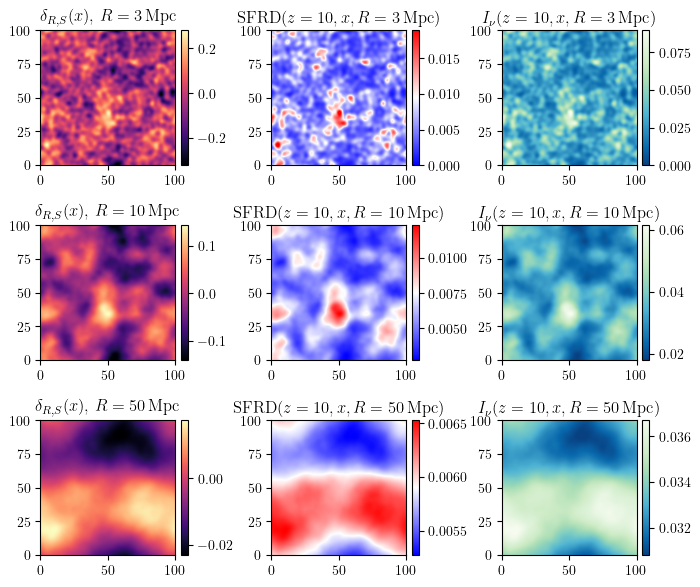

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7, 6))
R_vals = [3,10,50]
z0 = 10.
for r in range(len(R_vals)):

    smoothed_map_delta_z, smoothed_map_SFRD, smoothed_map_rhoL, smoothed_map_Inu  = smoothed_boxes(z0, R_vals[r],Lbox,Nbox,PS21_use,CoeffStructure_21_use, LineParams_use, AstroParams_use, HMFintclass_use, CosmoParams_use, use_interpolation = False, smooth_type='tophat')
    
    _islice = 0

    im = ax[r,0].imshow((smoothed_map_delta_z[_islice]),extent=(0,Lbox,0,Lbox),cmap='magma')#,vmax =0.25, vmin = -0.25) 
    cbar1 = fig.colorbar(im, ax=ax[r,0], fraction=0.046, pad=0.04)
    ax[r,0].set_title(r'$\delta_{R,S}(x),\,R=%g\,{\rm Mpc}$'%R_vals[r])

    if r == 0:
        im = ax[r,1].imshow((smoothed_map_SFRD[_islice]),extent=(0,Lbox,0,Lbox),cmap='bwr',vmax=0.019,vmin=0)
    else:
        im = ax[r,1].imshow((smoothed_map_SFRD[_islice]),extent=(0,Lbox,0,Lbox),cmap='bwr')
    cbar1 = fig.colorbar(im, ax=ax[r,1], fraction=0.046, pad=0.04)
    ax[r,1].set_title(r'${\rm SFRD}(z=%g$'%z0+r'$,{x},R=%g\,{\rm Mpc})$'%R_vals[r])

    # im = ax[r,2].imshow((smoothed_map_rhoL[_islice]),extent=(0,Lbox,0,Lbox),cmap=get_cmap('GnBu_r'),)
    # cbar1 = fig.colorbar(im, ax=ax[r,2], fraction=0.046, pad=0.04)
    # ax[r,2].set_title(r'$\log_{10}\rho_{L}(z=%g$'%z0+r'$,{x},R=%g\,{\rm Mpc})$'%R_vals[r])

    if r == 0:
        im = ax[r,2].imshow((smoothed_map_Inu[_islice]),extent=(0,Lbox,0,Lbox),cmap=get_cmap('GnBu_r'),vmin=0.,vmax = 0.09)
    else:
        im = ax[r,2].imshow((smoothed_map_Inu[_islice]),extent=(0,Lbox,0,Lbox),cmap=get_cmap('GnBu_r'),)
    cbar1 = fig.colorbar(im, ax=ax[r,2], fraction=0.046, pad=0.04)
    ax[r,2].set_title(r'${I_\nu}(z=%g$'%z0+r'$,{x},R=%g\,{\rm Mpc})$'%R_vals[r])


plt.tight_layout()
plt.savefig('./plots/filtered_boxes.png')
plt.show()
